## P5 - Vehicle Detection Project
----

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

## 1. Import libraries

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import glob
import cv2
import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from sklearn.svm import LinearSVC
from skimage.feature import hog
from tqdm import tqdm

%matplotlib inline

## 2 Load Training Data

In [2]:
vehicles= glob.glob('data/vehicles/vehicles/**/*.png')
non_vehicles = glob.glob('data/non-vehicles/non-vehicles/**/*.png')
len(vehicles),len(non_vehicles)

(8792, 8968)

## 2.1 Visualize Data

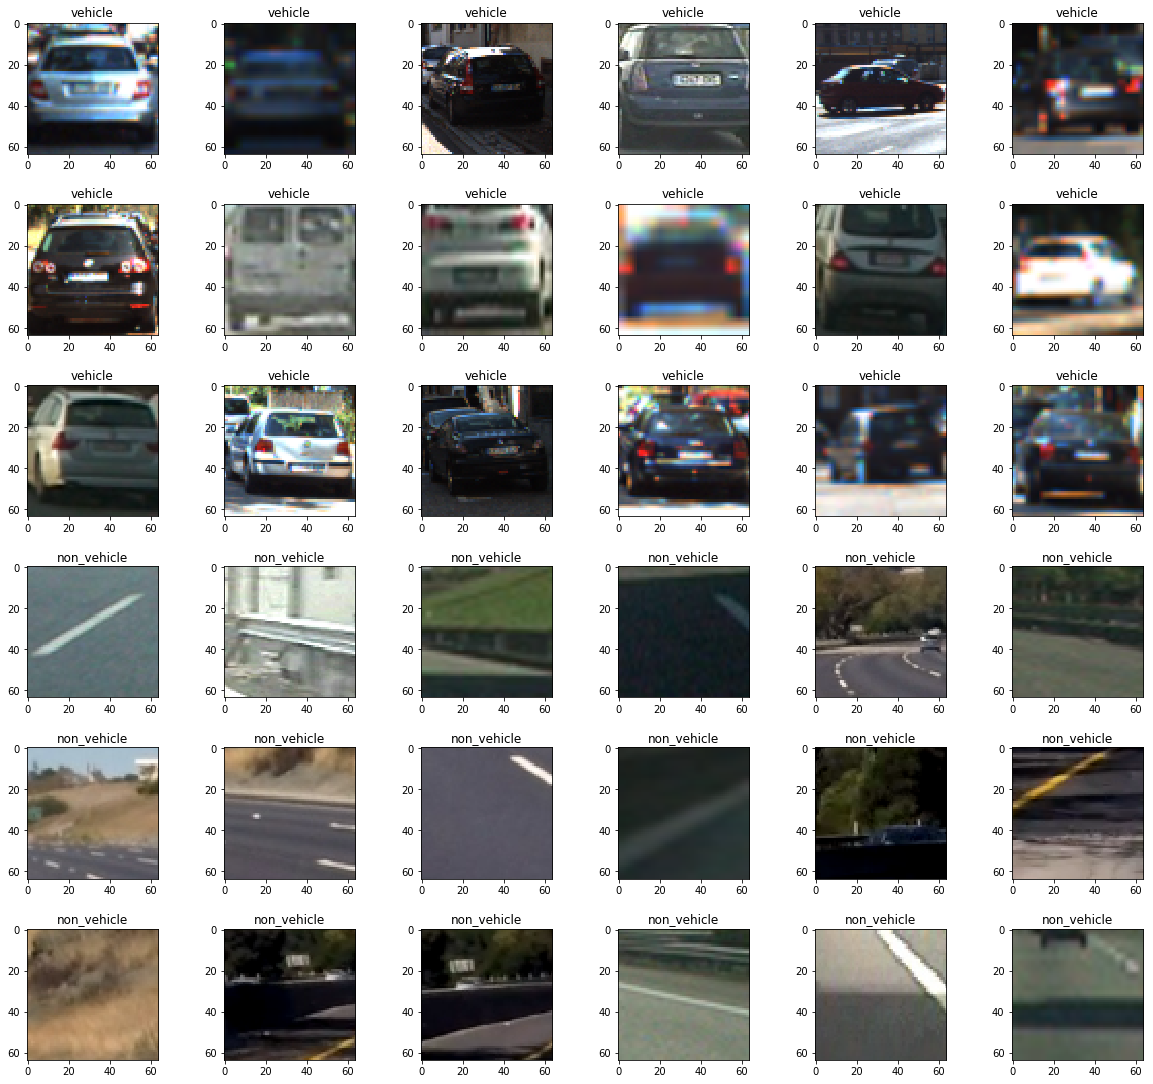

In [3]:
fig, axs = plt.subplots(6,6, figsize=(20, 20))
fig.subplots_adjust(hspace=0, wspace=0.5)
axs = axs.ravel()

# Show 18 images of the car.
for i in range(18):
    vehicle_path = vehicles[np.random.randint(0,len(vehicles))]
    img = mpimg.imread(vehicle_path)
    axs[i].set_title('vehicle')
    axs[i].imshow(img)

# Show 18 images of the not car.
for i in range(18,36):
    non_vehicle_path = non_vehicles[np.random.randint(0,len(non_vehicles))]
    img = mpimg.imread(non_vehicle_path)
    axs[i].set_title('non_vehicle')
    axs[i].imshow(img)

## 3. Define a function to return HOG features and visualization
The scikit-image `hog()` function takes in a single color channel or grayscaled image as input, as well as various parameters.

Parameters:
 
`orientations` is specified as an integer, and represents the number of orientation bins that the gradient information will be split up into in the histogram. Typical values are between 6 and 12 bins.

`pixels_per_cell`is specifies the cell size over which each gradient histogram is computed. 

`cells_per_block` is also passed as a 2-tuple, and specifies the local area over which the histogram counts in a given cell will be normalized. 

`transform_sqrt` is another optional power law or "gamma" normalization scheme set.

In [3]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=True, feature_vector=False, block_norm="L2-Hys")
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec, block_norm="L2-Hys")
        return features

#### 3.Test get_hog_features() :

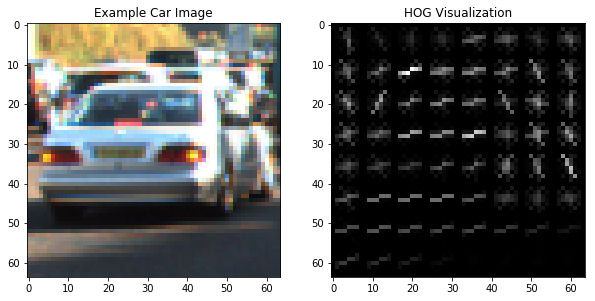

In [6]:
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
# Get a picture
ind = np.random.randint(0, len(vehicles))
car_img = mpimg.imread(vehicles[ind])
# Converted to grayscale
gray_car_img = cv2.cvtColor(car_img, cv2.COLOR_RGB2GRAY)
# Get the hog picture of the car.
_, car_hog_image = get_hog_features(gray_car_img, orient, pix_per_cell, cell_per_block, 
                                    vis=True, feature_vec=False)
# Plot the examples
fig = plt.figure(figsize = (10,10))
plt.subplot(121)
plt.imshow(car_img)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(car_hog_image, cmap='gray')
plt.title('HOG Visualization')
plt.savefig('output_images/hog_visualization.png', bbox_inches="tight")

## 4.Define a function to compute color histogram features 

`color_hist`is takes an image and computes the RGB color histogram of features given a particular number of bins and pixels intensity range, and returns the concatenated RGB feature vector.

`np.histogram()` is returns a tuple of two arrays.

Two arrays:

`channel1_hist[0]` is contains the counts in each of the bins.

`channel1_hist[1]` is contains the bin edges.

In [4]:
def color_hist(img, nbins=32, bins_range=(0, 256), vis=False):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    
    # Generating bin centers
    bin_edges = channel1_hist[1] #all three bins are the same size
    bin_centers = (bin_edges[1:] + bin_edges[0:len(bin_edges) - 1])/2
    
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    
    # Return the individual histograms, bin_centers and feature vector
    if vis == True:
        return channel1_hist, channel2_hist, channel3_hist, bin_centers
    else:
        return hist_features

#### 4.Test color_hist() :

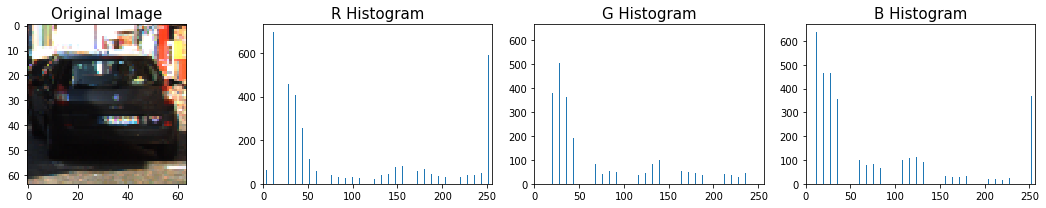

In [8]:
# Generate a random index to look at a car image
ind = np.random.randint(0, len(vehicles))
# Read in the image
img = cv2.imread(vehicles[ind])
image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# Compute color histogram features of the test image
channel1_hist, channel2_hist, channel3_hist, bin_centers = color_hist(image, vis=True)

# Plot a figure with all three bar charts
if channel1_hist is not None:
    fig = plt.figure(figsize=(15,3))
    plt.subplot(141)
    plt.imshow(image)
    plt.title('Original Image', fontsize=15)
    plt.subplot(142)
    plt.bar(bin_centers, channel1_hist[0])
    plt.xlim(0, 256)
    plt.title('R Histogram', fontsize=15);
    plt.subplot(143)
    plt.bar(bin_centers, channel2_hist[0])
    plt.xlim(0, 256)
    plt.title('G Histogram', fontsize=15);
    plt.subplot(144)
    plt.bar(bin_centers, channel3_hist[0])
    plt.xlim(0, 256)
    plt.title('B Histogram', fontsize=15);
    fig.tight_layout()
else:
    print('Your function is returning None for at least one variable...')

# save output image
plt.savefig('output_images/color_hist_vis.png', bbox_inches="tight")

## 5.Define a function to compute color histogram features

`bin_spatial()`is convert this to a one dimensional feature vector.`cv2.resize()` is a convenient function for scaling down the resolution.`*.ravel()` is convert this to a one dimensional feature vector.

In [5]:
# Define a function to compute color histogram features  
# Pass the color_space flag as 3-letter all caps string
# like 'HSV' or 'LUV' etc.
def bin_spatial(img, color_space='RGB', size=(32, 32)):
    # Convert image to new color space (if specified)
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)             
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(feature_image, size).ravel() 
    # Return the feature vector
    return features

#### 5.Test bin_spatial() :

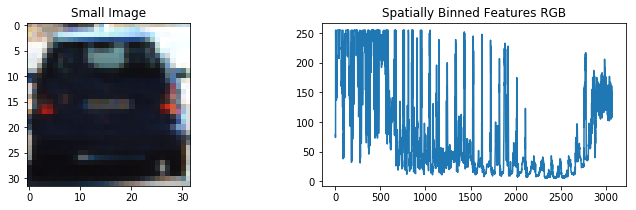

In [10]:
# apply bin_spatial function
feature_vec1 = bin_spatial(image, color_space='RGB', size=(32, 32))
# Get random number
ind = np.random.randint(0, len(vehicles))
# Read in the image and Change the size to (32, 32)
image = mpimg.imread(vehicles[ind])
small_image = cv2.resize(image, (32, 32))
# Plot features
fig = plt.figure(figsize=(12,3))
plt.subplot(121)
plt.imshow(small_image)
plt.title('Small Image')
plt.subplot(122)
plt.plot(feature_vec1)
plt.title('Spatially Binned Features RGB')
# save output image
plt.savefig('output_images/bin_spatial1.png', bbox_inches="tight")

## 6. Define a function to extract features from a list of image locations

This function could used to call `bin_spatial()` , `color_hist()` and `get_hog_features()` to extract flattened spatial color features and color histogram features and HOG features and combine them all (making use of StandardScaler) to be used together for classification.

In [6]:
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                      hist_bins=32, orient=9, pix_per_cell=8, cell_per_block=2, 
                     hog_channel=0, spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in tqdm(imgs):
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            # Apply bin_spatial() to get spatial color features
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
            
        if hist_feat == True:
            # Apply color_hist() also with a color space option now
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
            
        if hog_feat == True:
            # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            file_features.append(hog_features)
        # Append the new feature vector to the features list
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

#### 6. Test extract_features() :

In [ ]:
t = time.time()
car_features = extract_features(vehicles, hog_feat=True)
notcar_features = extract_features(non_vehicles, hog_feat=True)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)

print('Using:', orient, 'orientations', pix_per_cell, 'pixels per cell and', cell_per_block, 'cells per block')
print('Feature vector length:', len(X_train[0]))

## 7. Sliding Window

Define a function that takes an image,start and stop positions in both x and y, window size (x and y dimensions), and overlap fraction (for both x and y).

In [7]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                 xy_window=(128, 128), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

#### 7.Test slide_window() :

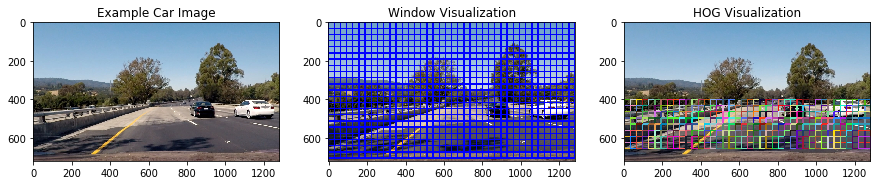

In [8]:
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(255,0,0), thick=6, random_color=False):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Random color code copied from jeremy-shannon
        if random_color == True:
            color = (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

# Read the image
test_img = mpimg.imread('test_images/test4.jpg')

# Window Visualization
f_windows = slide_window(test_img, x_start_stop=[None, None], y_start_stop=[None, None], 
                         xy_window=(64, 64), xy_overlap=(0.5, 0.5))
f_window_img = draw_boxes(test_img, f_windows, color=(0,0,255), thick=6)   
# The options window Visualization
windows =  slide_window(test_img, x_start_stop=[None, None], y_start_stop=[400, 656], 
                        xy_window=(64, 64),xy_overlap=(0.5, 0.5))
window_img = draw_boxes(test_img, windows, random_color=True)

# Plot the examples
fig = plt.figure(figsize = (15,15))
plt.subplot(131)
plt.imshow(test_img)
plt.title('Example Car Image')
plt.subplot(132)
plt.imshow(f_window_img)
plt.title('Window Visualization')
plt.subplot(133)
plt.imshow(window_img)
plt.title('HOG Visualization')

# save output image
plt.savefig('output_images/sliding_windows.png', bbox_inches="tight")

## 8. Defining a function to extract features from a single image window

This function is very similar to `extract_features()` just for a single image rather than list of images.

In [9]:
def single_img_features(image, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(image)
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                                            pix_per_cell, cell_per_block,
                                            vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)
    #9) Return concatenated array of features
    return np.concatenate(img_features)

## 8.1 The list of windows to be searched (output of slide_windows())

The function, based on the box that `slide_windows()` calculates, predicts whether it is a car, and finally, the box of the car is placed in the list as the return value.

In [10]:
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                   spatial_size=(32, 32), hist_bins=32, orient=9, 
                   pix_per_cell=8, cell_per_block=2, hog_channel=0,
                   spatial_feat=True, hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

#### 8.Test single_img_features() and search_windows()

1.Get the feature vectors of cars and non-cars.

In [11]:
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 10  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 64   # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
# Extract the eigenvectors and calculate the elapsed time.
t = time.time()
car_features = extract_features(vehicles, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel,
                            spatial_feat=spatial_feat, hist_feat=hist_feat,
                            hog_feat=hog_feat)
notcar_features = extract_features(non_vehicles, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel,
                            spatial_feat=spatial_feat, hist_feat=hist_feat,
                            hog_feat=hog_feat)
t2 = time.time()
# Displays the time taken to extract.
print(round(t2-t, 2), 'Seconds to extract HOG features...')

100%|█████████████████████████████████████| 8968/8968 [01:19<00:00, 113.46it/s]


159.15 Seconds to extract HOG features...


2.Divide the data into 80% training set and 20% test set and normalized.

In [12]:
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)
# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
# Print related parameter information.
print('Using:', orient, 
      'orientations', pix_per_cell, 
      'pixels per cell and', cell_per_block, 'cells per block')
print('Feature vector length:', len(scaled_X[0]))
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

Using: 10 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 9144


3.Use the classifier linear SVM for training.

In [13]:
# Use a linear SVC 
svc = LinearSVC()
# # Check the training time for the SVC
t = time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('These',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

31.37 Seconds to train SVC...
Test Accuracy of SVC =  0.9862
My SVC predicts:  [ 0.  1.  1.  1.  0.  1.  0.  1.  1.  0.]
These 10 labels:  [ 0.  1.  1.  1.  0.  1.  0.  1.  1.  0.]
0.14021 Seconds to predict 10 labels with SVC


4.Find the car in the test image.

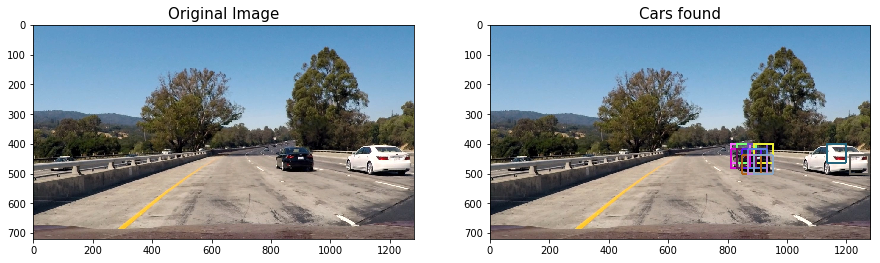

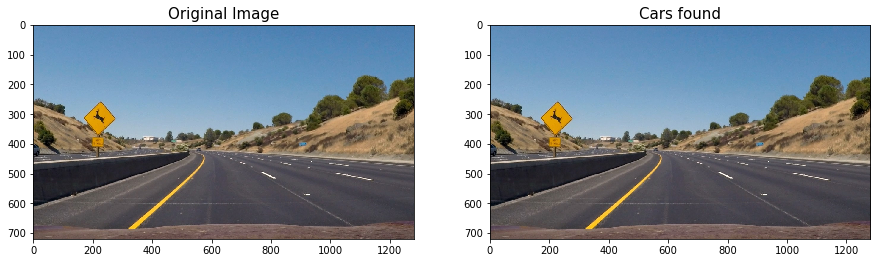

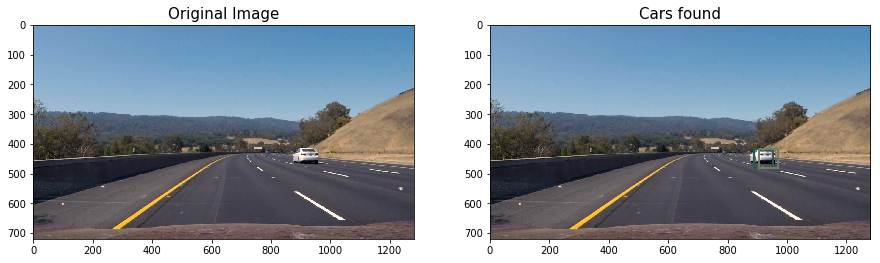

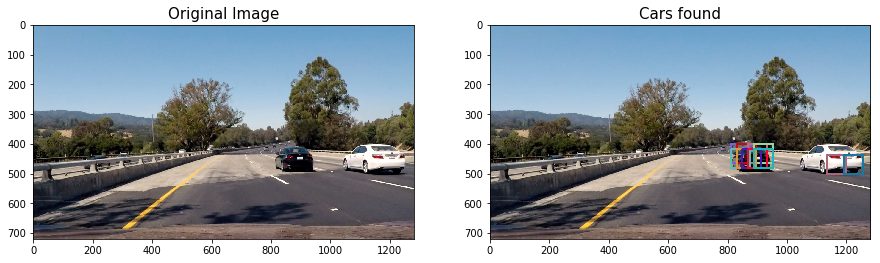

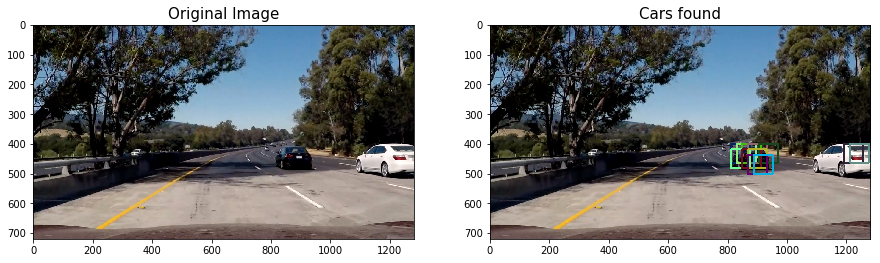

In [72]:
for i in range(5):
    
    # Read the image
    test_img = mpimg.imread('test_images/test{}.jpg'.format(i+1))
    # cpoy the image to draw
    draw_image = np.copy(test_img)

    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    image = test_img.astype(np.float32)/255

    # Calculate the silde window
    windows = slide_window(test_img,x_start_stop=[600, None],
                            y_start_stop=[400, 550],xy_window=(64,64),
                            xy_overlap=(.7,.7))

    # Extract the image of each window and predict the image.
    box_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       

    # The predicted results are drawn in the image.
    window_img = draw_boxes(draw_image, box_windows, random_color=True) 

    # show image
    fig = plt.figure(figsize=(15,15))
    plt.subplot(121)
    plt.imshow(test_img)
    plt.title('Original Image', fontsize=15)
    plt.subplot(122)
    plt.imshow(window_img)
    plt.title('Cars found', fontsize=15)
    # save output image
    plt.savefig('output_images/windows{}.png'.format(i+1), bbox_inches="tight")

## 9.Define a single function that can extract features using hog sub-sampling and make predictions

`find_cars` that's able to both extract features and make predictions.

In [16]:
def find_cars(img, ystart, ystop, scale, svc, X_scaler,
              orient, pix_per_cell, cell_per_block,
              spatial_size, hist_bins, show_all_rectangles=False):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch,(np.int(imshape[1]/scale),np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    bbox_list=[] #https://github.com/preritj/Vechicle-Detection-Tracking
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features,
                                                          hist_features,
                                                          hog_features)).reshape(1, -1))  
            
            # Scale features and make a prediction  
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1 or show_all_rectangles == True:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
#                 cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),
#                               (xbox_left+win_draw,ytop_draw+win_draw+ystart),
#                               (255,0,0),5)
                bbox_list.append(((xbox_left, ytop_draw+ystart), 
                                  (xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return bbox_list

# Change the color space of the image.
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'RGB2HLS':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)

#### 9.Test find_cars() function:

10 rectangles found in image
1 rectangles found in image
2 rectangles found in image
11 rectangles found in image
14 rectangles found in image


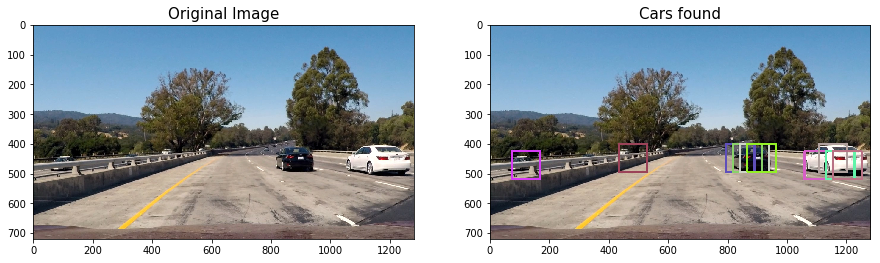

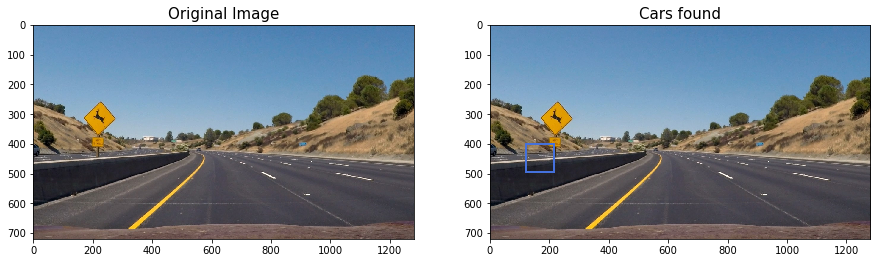

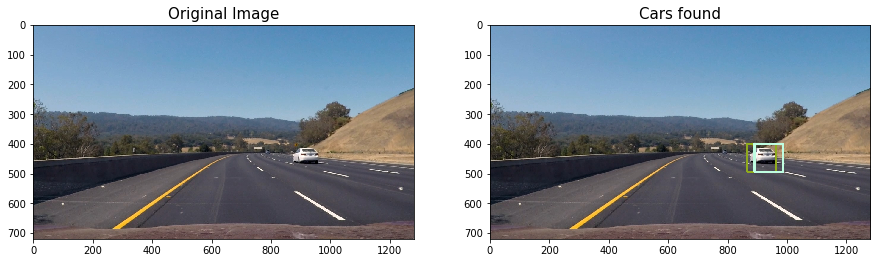

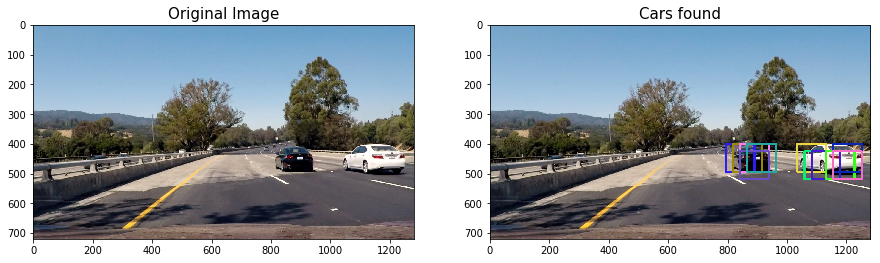

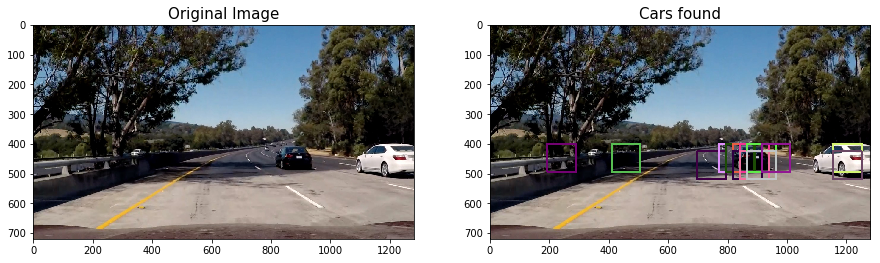

In [124]:
for i in range(5):
    # Set the parameters
    test_img = mpimg.imread('./test_images/test{}.jpg'.format(i+1))
    ystart = 400
    ystop = 545
    scale = 1.5
    orient = 9
    pix_per_cell = 8
    cell_per_block = 2
    spatial_size = (32, 32)
    hist_bins = 32
    # Gets the box image and box coordinates of the car.
    rectangles = find_cars(test_img, ystart, ystop, scale, 
                           svc, X_scaler, orient, pix_per_cell, cell_per_block,
                           spatial_size, hist_bins)
    # draw box to image
    rects_img = draw_boxes(test_img, rectangles, random_color=True)
    # Print the completed box.
    print(len(rectangles), 'rectangles found in image')
    # Displays the original image and the car's box image.
    fig = plt.figure(figsize=(15,15))
    plt.subplot(121)
    plt.imshow(test_img)
    plt.title('Original Image', fontsize=15)
    plt.subplot(122)
    plt.imshow(rects_img)
    plt.title('Cars found', fontsize=15)
    # save output image
    plt.savefig('output_images/find_car{}.png'.format(i+1), bbox_inches="tight")

## 10. Adding heatmaps , bounding boxes and find cars Method

In [14]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (255,0,0), 8)
    # Return the image
    return img

#### 10.Test add_heat() :

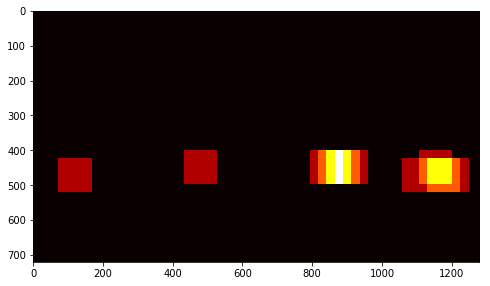

In [110]:
# Get the heatmap image
heatmap_img = np.zeros_like(test_img[:,:,0])
heatmap_img = add_heat(heatmap_img, rectangles)
# show the image and save
plt.figure(figsize=(8,8))
plt.imshow(heatmap_img, cmap='hot')
plt.savefig('output_images/heatmap.png', bbox_inches="tight")

#### 10.Test apply_threshold() :

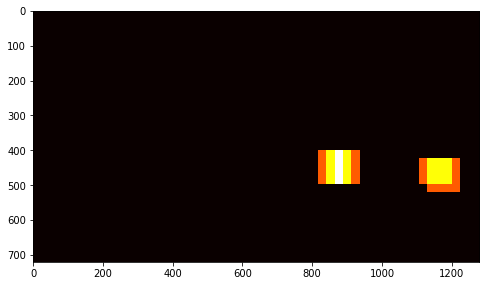

In [111]:
# apply threshold
heatmap_img = apply_threshold(heatmap_img, 1)
# show the image and save 
plt.figure(figsize=(8,8))
plt.imshow(heatmap_img, cmap='hot')
plt.savefig('output_images/apply_threshold.png', bbox_inches="tight")

#### 10.Test draw_labeled_bboxes() :

2 cars found


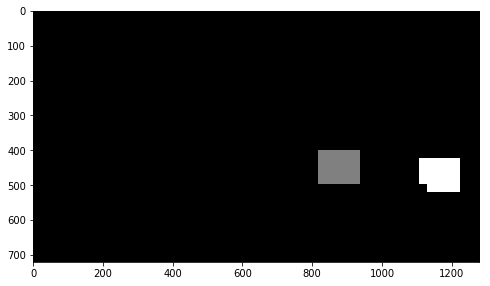

In [113]:
# use labels get the image
labels = label(heatmap_img)
# show the image and save
plt.figure(figsize=(8,8))
plt.imshow(labels[0], cmap='gray')
print(labels[1], 'cars found')
plt.savefig('output_images/label.png', bbox_inches="tight")

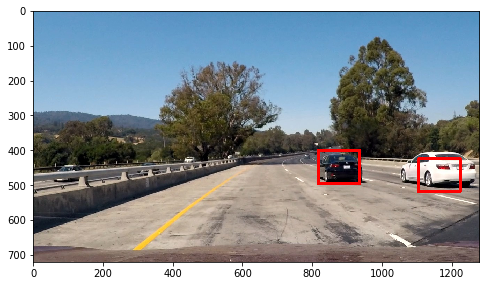

In [118]:
# Draw bounding boxes on a copy of the image
new_img = draw_labeled_bboxes(np.copy(test_img), labels)
# Display the image and save
plt.figure(figsize=(8,8))
plt.imshow(new_img)
plt.savefig('output_images/draw_labeled_bboxes', bbox_inches="tight")

#### 10.Test add_heat() , Test apply_threshold() , draw_labeled_bboxes()  :

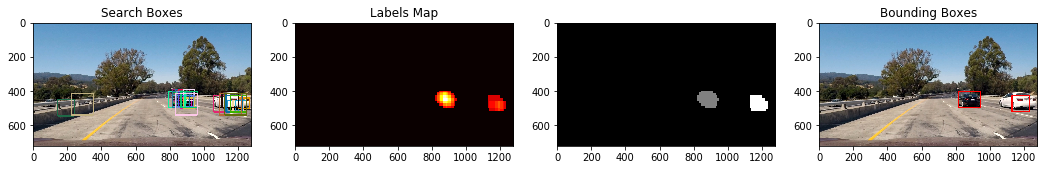

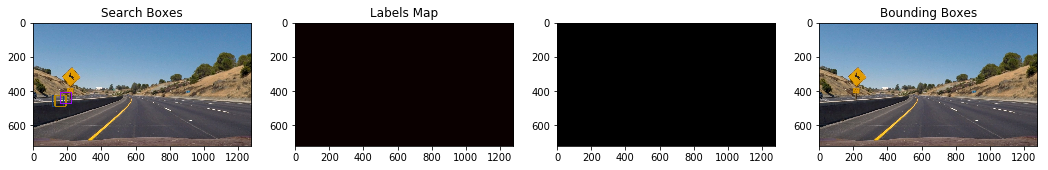

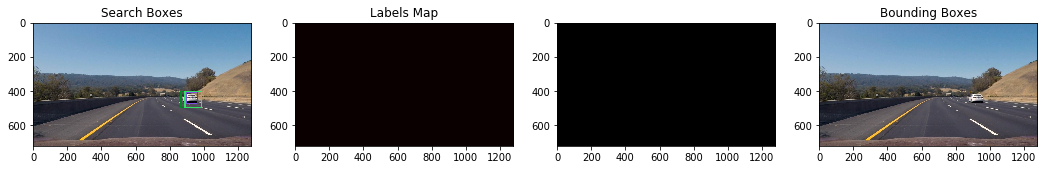

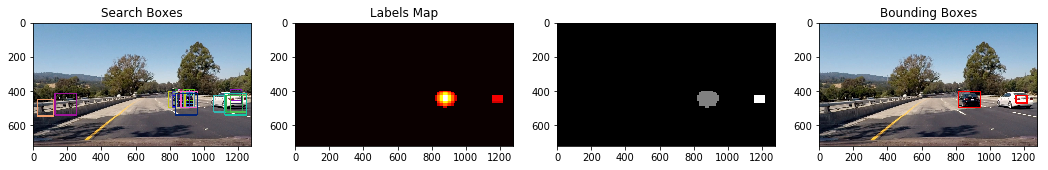

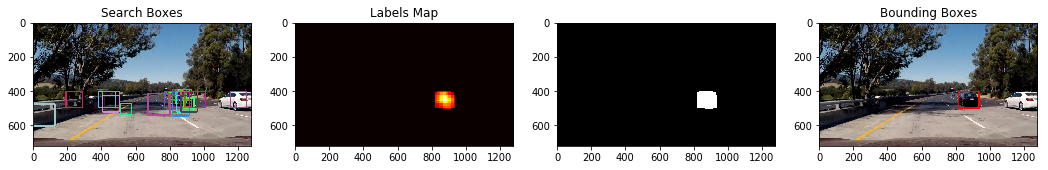

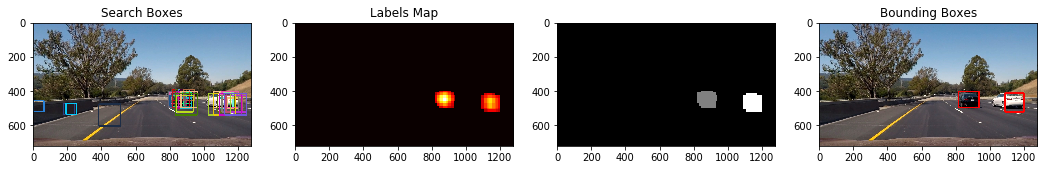

In [39]:
for i in range(6):
    
    # Save the location of all found cars.
    bbox_list = []
    # Read image
    img = mpimg.imread('test_images/test{}.jpg'.format(i+1))

    # Set the parameters.
    orient = 10
    pix_per_cell = 8
    cell_per_block = 2
    spatial_size = (32, 32)
    hist_bins = 64

    # Set the image range.
    ystart = 390
    ystop = 550
    scale = 1.0
    # Get the car box.
    bbox_list.append(find_cars(img, ystart, ystop, scale, svc, X_scaler,
                                    orient, pix_per_cell, cell_per_block,
                                    spatial_size, hist_bins))
    
    # Set the image range.
    ystart = 400
    ystop = 600
    scale = 1.5
    bbox_list.append(find_cars(img, ystart, ystop, scale, svc, X_scaler,
                                    orient, pix_per_cell, cell_per_block,
                                    spatial_size, hist_bins))
    
    # Set the image range.
    ystart = 410
    ystop = 650
    scale = 2.0
    # Get the car box.
    bbox_list.append(find_cars(img, ystart, ystop, scale, svc, X_scaler,
                                    orient, pix_per_cell, cell_per_block,
                                    spatial_size, hist_bins))
    
    # Copied from 'jeremy-shannon'
    bbox_list = [item for sublist in bbox_list for item in sublist] 
    # Find the car in the picture and draw the box.
    out_img = draw_boxes(img, bbox_list, random_color=True)

    # Use a heat map to exclude a box that is not a car.
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    heat = add_heat(heat, bbox_list)
    heat = apply_threshold(heat, 4)  

    # Find final boxes from heatmap using label function
    labels = label(heat)
    new_img = draw_labeled_bboxes(np.copy(img), labels)

    # show the image
    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(18,9))
    ax1.imshow(out_img)
    ax1.set_title('Search Boxes')
    ax2.imshow(heat, cmap='hot')
    ax2.set_title('Heat Map')
    ax3.imshow(labels[0], cmap='gray')
    ax2.set_title('Labels Map')
    ax4.imshow(new_img)
    ax4.set_title('Bounding Boxes')
    # save output image
    plt.savefig('output_images/heat_labels_map{}.png'.format(i), bbox_inches="tight")

## 10 Video Ouput

In [34]:
def process_image(img):
    
    # Save the location of all found cars.
    bbox_list = []
    
    # Set the parameters.
    orient = 10
    pix_per_cell = 8
    cell_per_block = 2
    spatial_size=(32, 32)
    hist_bins = 64
    
    # Set the image range.
    ystart = 390
    ystop = 500
    scale = 1.0
    # Get the car box.
    bbox_list.append(find_cars(img, ystart, ystop, scale, svc, X_scaler,
                                    orient, pix_per_cell, cell_per_block,
                                    spatial_size, hist_bins))
    
    ystart = 400
    ystop = 550
    scale = 1.5
    bbox_list.append(find_cars(img, ystart, ystop, scale, svc, X_scaler,
                                    orient, pix_per_cell, cell_per_block,
                                    spatial_size, hist_bins))
    
    ystart = 410
    ystop = 600
    scale = 2.0
    bbox_list.append(find_cars(img, ystart, ystop, scale, svc, X_scaler,
                                    orient, pix_per_cell, cell_per_block,
                                    spatial_size, hist_bins))
    
    # Copied from 'jeremy-shannon'
    bbox_list = [item for sublist in bbox_list for item in sublist] 
    
    # Use a heat map to exclude a box that is not a car.
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    heat = add_heat(heat, bbox_list)
    heat = apply_threshold(heat, 4)  

    # Find final boxes from heatmap using label function
    labels = label(heat)
    new_img = draw_labeled_bboxes(np.copy(img), labels)
    
    return new_img

#### Test process_image() :

In [35]:
test_video_out = 'test_video_out.mp4'
clip_test = VideoFileClip('test_video.mp4')
clip_test_out = clip_test.fl_image(process_image)
%time clip_test_out.write_videofile(test_video_out, audio=False)

[MoviePy] >>>> Building video test_video_out.mp4
[MoviePy] Writing video test_video_out.mp4


 97%|████████████████████████████████████████▉ | 38/39 [00:32<00:00,  1.14it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out.mp4 

Wall time: 34.5 s


In [36]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_video_out))

#### Laugh process_image() :

In [37]:
project_output = "project_output.mp4"
clip = VideoFileClip("project_video.mp4")
clip = clip.fl_image(process_image)
%time clip.write_videofile(project_output, audio=False)

[MoviePy] >>>> Building video project_output.mp4
[MoviePy] Writing video project_output.mp4


100%|█████████████████████████████████████▉| 1260/1261 [17:57<00:00,  1.16it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output.mp4 

Wall time: 17min 58s


In [38]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))